# Классификация символов
Задача заключается в определении символа.
Датасет изображений. Включает в себя набор изображений символов (0-9,A-Z,a-z) полученных из фотографий.
По ссылке доступны для скачивания изображения с символами на языке Каннада, его скачивать не нужно
http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/,

### Мотивация

Распознавание символов - это классическая проблема распознавания образов для какие исследователи работали с первых дней компьютерной зрение. Сегодня камеры вездесущи, приложения автоматического распознавания символов шире, чем когда-либо. Для Латинским шрифтом, это в значительной степени считается решенной проблемой в ограниченные ситуации, такие как изображения отсканированных документов содержащие общие символьные шрифты и униформу задний план. Однако изображения, полученные с помощью популярных фотоаппаратов и портативные устройства по-прежнему представляют собой серьезную проблему для распознавание символов. Сложные аспекты этой проблемы очевидны в этом наборе данных.

In [1]:
# # Загрузим архив с изображениями.
# !wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz

# # распакуем архив.
# !tar -xvzf EnglishImg.tgz

In [2]:
# !git clone https://github.com/4uiiurz1/keras-arcface.git

# import sys
# sys.path.append('/content/keras_arcface/')

In [3]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from pathlib import Path
import random
import numpy as np
import math
import os
from shutil import copyfile
from tqdm import tqdm

import string
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2



import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.utils import to_categorical

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape,Dense,Flatten, Activation, Dropout, BatchNormalization, MaxPooling2D,InputLayer

### Подготовка данных.

In [4]:
# Создадим список с именами классов. 
class_name = []

for i in range(ord('0'), ord('9')+1):
    class_name.append(chr(i))

for i in range(ord('A'), ord('Z')+1):
    class_name.append(chr(i))

for i in range(ord('a'), ord('z')+1):
    class_name.append(chr(i))

In [5]:
# Заполним таблицу данными из папок. 
data = {'class_ind':[],
        'file_name':[]
       }
data_frame = pd.DataFrame(data)

In [6]:
num_classes = len(class_name)

In [7]:
path_goodimg = f'English/Img/GoodImg/Bmp/Sample'
path_badimg = f'English/Img/BadImag/Bmp/Sample'

In [8]:
train_df = pd.DataFrame(data)
test_df = pd.DataFrame(data)
val_df = pd.DataFrame(data)

### Разбиение выборки на train, test и validation.

In [9]:
np.random.seed(25)
random.seed(25)

In [10]:
for class_index in range(1, num_classes+1):
    folder_path = f'{path_goodimg}{class_index:03d}/'
    images_path = sorted([i for i in Path(folder_path).glob('*.png')])
    n_imgs = len(images_path)
    n_split = n_imgs//20
    random.shuffle(images_path)
    for i, img_name in enumerate(images_path):
        new_row = {'class_ind': class_index-1,
                   'file_name': str(img_name)
                  }
        if i < n_split: # test 
            test_df = test_df.append(new_row, ignore_index=True)
        elif n_split<=i<n_split*5: #validation
             val_df = val_df.append(new_row, ignore_index=True)
        else:          # train 
             train_df = train_df.append(new_row, ignore_index=True)

In [11]:
len(train_df), len(test_df), len(val_df)

(5940, 353, 1412)

In [12]:
def keras_generator(gen_df,batch_size=None,size_image=(128,128), preprocess_input=None, is_ArcFace = False):
    ind = np.arange(0,len(gen_df))
    random.shuffle(ind)

    if not batch_size:
            batch_size = len(images)

    while True:
        X_batch = []
        y_batch = []
          
        for i in range(batch_size):
          # class_ind, img_name = gen_df.values[ind[i]] # выдает случайный номер картинки. 
          class_ind, img_name = gen_df.sample(1).values[0]
          img = cv2.imread(img_name) 
          img = cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_BGR2RGB)

          img = cv2.resize(img, size_image)

          # преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
          y_batch.append(to_categorical(class_ind, num_classes))
          X_batch.append(img)
          
        if preprocess_input:
            X_batch = preprocess_input(np.array(X_batch))
        else:
            X_batch = np.array(X_batch, dtype='float')/255.0

        y_batch = np.array(y_batch, dtype='uint8')
        
        # c += batch_size
        # if(c+batch_size>=len(ind)):
        #     c = 0
        #     random.shuffle(ind)
        
        if is_ArcFace:
          out = [X_batch, y_batch], y_batch
        else:
          out = X_batch, y_batch
          
        yield out

In [13]:
IMAGE_SIZE=128
num_classes = 62
batch_size = 6
num_classes = len(class_name)
epochs = 20

In [14]:
num_classes = 62
image_resize = 128
batch_size_training = 16
batch_size_validation = 16
batch_size_testing = 16

In [15]:
def show_images(images,labels_ind, true_ind=None):
    num_of_images = len(images)
    fig, axes = plt.subplots(1, num_of_images, 
            figsize=(3 * num_of_images, 3 * num_of_images) # Размер изображений будет зависет от из к-ва в строке. 
            )
    for i, (image_pixels,label_ind) in enumerate(zip(images,labels_ind)):
        
        title_text = class_name[np.argmax(label_ind)]
        if true_ind is not None:
            title_text+=f' true = {class_name[np.argmax(true_ind[i])]}'

        axes[i].imshow(image_pixels)
        axes[i].title.set_text(title_text)

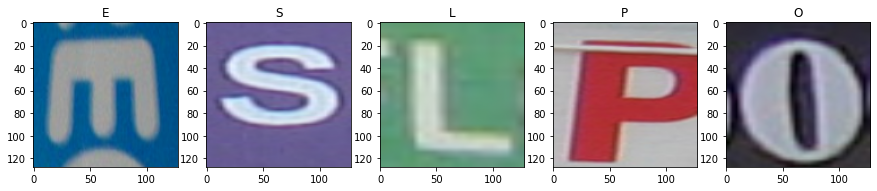

In [16]:
# Проверим работу генератора.

for batchX,batchy in keras_generator(train_df,batch_size=batch_size,size_image=(IMAGE_SIZE,IMAGE_SIZE)):
    break

show_images(batchX[0:5], batchy[0:5])

### Строим модель. 

In [17]:
from keras.optimizers import Adam

In [18]:
# # конфигурирование слоев нейросети
# softmax_model = Sequential()

# softmax_model.add(InputLayer(input_shape = (128, 128, 3)))

# softmax_model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
# softmax_model.add(BatchNormalization())
# softmax_model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
# softmax_model.add(BatchNormalization())

# # model.add(MaxPooling2D(pool_size=(2, 2)))
# softmax_model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

# softmax_model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
# softmax_model.add(BatchNormalization())
# softmax_model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
# softmax_model.add(BatchNormalization())

# softmax_model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

# # полносвязные слои нейронной сети
# softmax_model.add(Flatten())
# softmax_model.add(Dense(256,activation=Activation('relu')))
# softmax_model.add(BatchNormalization())
# softmax_model.add(Dense(256,activation=Activation('relu')))
# softmax_model.add(BatchNormalization())
# softmax_model.add(Dense(num_classes,activation=Activation('softmax')))

# softmax_model.summary()

# # компиляция модели
# softmax_model.compile(loss='categorical_crossentropy',
#               optimizer= 'Adam',# Adam(learning_rate = 0.0005), #op 'Adam', #optimizer,
#               metrics=['accuracy'])

In [25]:
# конфигурирование слоев нейросети
softmax_model = Sequential()

softmax_model.add(InputLayer(input_shape = (128, 128, 3)))

softmax_model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
softmax_model.add(BatchNormalization())
softmax_model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
softmax_model.add(BatchNormalization())

# model.add(MaxPooling2D(pool_size=(2, 2)))
softmax_model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

softmax_model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
softmax_model.add(BatchNormalization())
softmax_model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
softmax_model.add(BatchNormalization())

softmax_model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

# полносвязные слои нейронной сети
softmax_model.add(Flatten())
softmax_model.add(Dense(256,activation=Activation('relu')))
# model.add(BatchNormalization())
softmax_model.add(Dropout(0.3))
softmax_model.add(Dense(256,activation=Activation('relu')))
# model.add(BatchNormalization())
softmax_model.add(Dropout(0.3))
softmax_model.add(Dense(num_classes,activation=Activation('softmax')))

softmax_model.summary()

optimizer = Adam(learning_rate = 0.0001)

# компиляция модели
softmax_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)       

In [26]:
steps_per_epoch_training = len(train_df)//batch_size_training #1000# len(train_generator)
steps_per_epoch_validation = len(val_df)//batch_size_validation
steps_per_epoch_testing = len(test_df)//batch_size_testing
num_epochs = 100

steps_per_epoch_training, steps_per_epoch_validation, steps_per_epoch_testing

(371, 88, 22)

In [27]:
train_generator = keras_generator(train_df,batch_size=batch_size_training,size_image=(IMAGE_SIZE,IMAGE_SIZE))

test_generator = keras_generator(test_df,batch_size=batch_size_testing,size_image=(IMAGE_SIZE,IMAGE_SIZE))

val_generator = keras_generator(val_df,batch_size=batch_size_validation,size_image=(IMAGE_SIZE,IMAGE_SIZE))

In [28]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=7,
                              restore_best_weights=True)

In [29]:
#fit model
fit_history = softmax_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch_training,
    epochs = num_epochs,
    validation_data = test_generator,
    validation_steps = steps_per_epoch_testing,
    callbacks = [early_stopping],
    verbose = 1
)

Epoch 1/100
371/371 [==============================] - 41s 65ms/step - loss: 4.4937 - accuracy: 0.0477 - val_loss: 4.1387 - val_accuracy: 0.1051
Epoch 2/100
371/371 [==============================] - 19s 51ms/step - loss: 3.6435 - accuracy: 0.1402 - val_loss: 2.9846 - val_accuracy: 0.3352
Epoch 3/100
371/371 [==============================] - 18s 49ms/step - loss: 3.3016 - accuracy: 0.2094 - val_loss: 2.6859 - val_accuracy: 0.3636
Epoch 4/100
371/371 [==============================] - 18s 50ms/step - loss: 2.9162 - accuracy: 0.2973 - val_loss: 2.4738 - val_accuracy: 0.4744
Epoch 5/100
371/371 [==============================] - 18s 49ms/step - loss: 2.6293 - accuracy: 0.3525 - val_loss: 2.3295 - val_accuracy: 0.4716
Epoch 6/100
371/371 [==============================] - 18s 48ms/step - loss: 2.4721 - accuracy: 0.3809 - val_loss: 2.2021 - val_accuracy: 0.4716
Epoch 7/100
371/371 [==============================] - 18s 48ms/step - loss: 2.2392 - accuracy: 0.4398 - val_loss: 1.8649 - val_ac

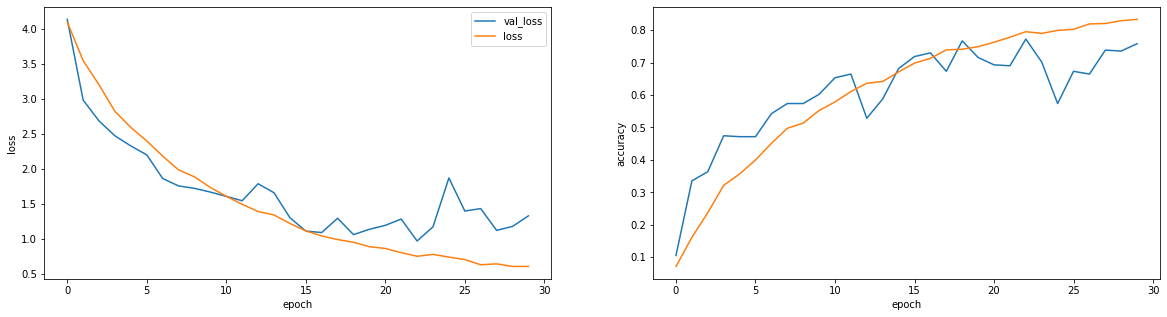

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

axes[0].plot(fit_history.history['val_loss'], label='val_loss')
axes[0].plot(fit_history.history['loss'], label='loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot(fit_history.history['val_accuracy'], label='val_accuracy')
axes[1].plot(fit_history.history['accuracy'], label='accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[0].legend()

plt.show()

In [31]:
#evaluate the model
eval = softmax_model.evaluate(test_generator, steps = steps_per_epoch_testing, verbose=0)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

Model performance:
loss for test dataset is : 1.1545448303222656
accuracy for test dataset is : 0.7215909361839294


In [32]:
#evaluate the model
eval = softmax_model.evaluate(val_generator, steps = steps_per_epoch_validation, verbose=0)
print('Model performance:')
print('loss for validation dataset is : {}'.format(eval[0]))
print('accuracy for validation dataset is : {}'.format(eval[1]))

Model performance:
loss for validation dataset is : 1.3366265296936035
accuracy for validation dataset is : 0.6875


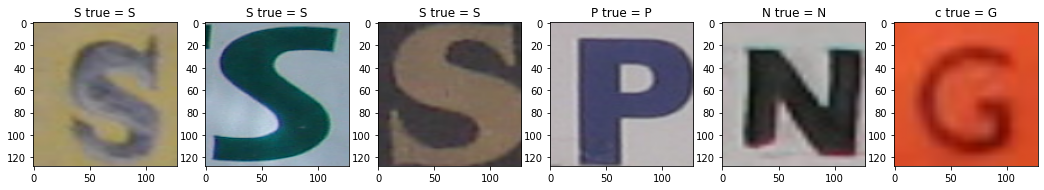

In [33]:
for batchX, batchy in val_generator:
    break

pred = softmax_model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

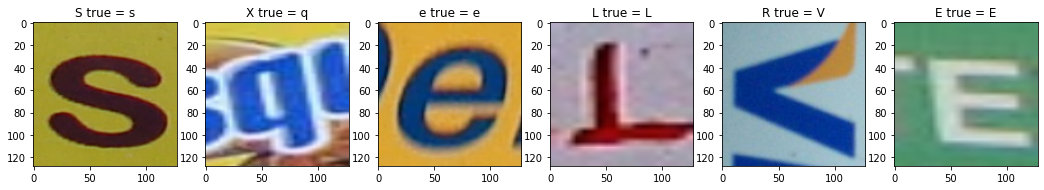

In [34]:
for batchX, batchy in val_generator:
    break
pred = softmax_model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

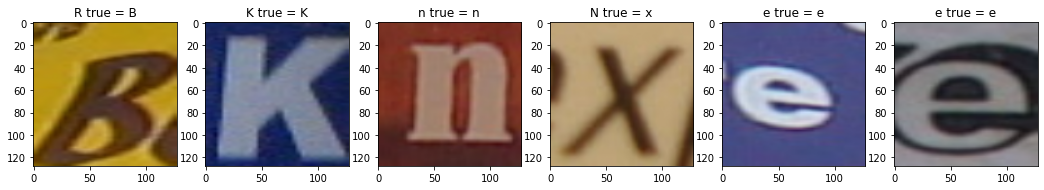

In [35]:
for batchX, batchy in val_generator:
    break
pred = softmax_model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

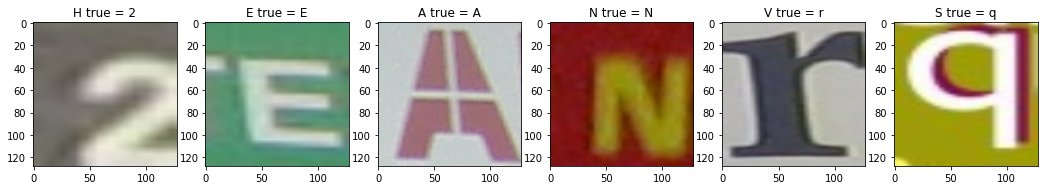

In [36]:
for batchX, batchy in val_generator:
    break
pred = softmax_model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

In [37]:
softmax_model.save_weights('Char74K_keras_softmax.h5')

### Попробуем улучшить результат с помощью Metric Learning.

In [94]:
# сменим название папки с проектом.

In [95]:
from keras_arcface.metrics import ArcFace

from keras.layers import Input
from keras.models import Model

In [96]:
steps_per_epoch_training = len(train_df)//batch_size_training #1000# len(train_generator)
steps_per_epoch_validation = len(val_df)//batch_size_validation
steps_per_epoch_testing = len(test_df)//batch_size_testing
num_epochs = 20

steps_per_epoch_training, steps_per_epoch_validation, steps_per_epoch_testing

(371, 88, 22)

In [97]:
train_generator = keras_generator(train_df,batch_size=batch_size_training,size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=True)

test_generator = keras_generator(test_df,batch_size=batch_size_testing,size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=True)

val_generator = keras_generator(val_df,batch_size=batch_size_validation,size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=True)


In [98]:
# конфигурирование слоев нейросети
label = Input(shape = (num_classes,))
input = Input(shape = (128, 128, 3))

x = Conv2D(filters=32, kernel_size=3,activation='relu', padding='same')(input)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=3,activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# model.add(MaxPooling2D(pool_size=(2, 2)))
x = MaxPooling2D(pool_size = (2,2),strides = (2,2))(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = MaxPooling2D(pool_size = (2,2),strides = (2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# полносвязные слои нейронной сети
x = Flatten()(x)
x = Dense(256,activation=Activation('relu'))(x)
x = BatchNormalization()(x)
x = Dense(32,activation=Activation('relu'))(x)
x = BatchNormalization()(x)
# x = odel.add(Dense(num_classes,activation=Activation('softmax'))(x)

output = ArcFace(num_classes, m=1)([x, label])

model_1 = Model([input, label], output)
model_1.summary()

# компиляция модели
model_1.compile(loss='categorical_crossentropy',
              optimizer='Adam', #optimizer,
              metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 128, 32) 128         conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 32) 9248        batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [99]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=10,
                              restore_best_weights=True)

In [100]:
#fit model
fit_history = model_1.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch_training,
    epochs = num_epochs,
    validation_data = test_generator,
    validation_steps = steps_per_epoch_testing,
    callbacks = [early_stopping],
    # validation_batch_size=
    verbose = 1
)

Epoch 1/20
371/371 [==============================] - 21s 51ms/step - loss: 32.2057 - accuracy: 0.0000e+00 - val_loss: 27.7462 - val_accuracy: 0.0000e+00
Epoch 2/20
371/371 [==============================] - 19s 51ms/step - loss: 19.5932 - accuracy: 0.0851 - val_loss: 3.6187 - val_accuracy: 0.8580
Epoch 3/20
371/371 [==============================] - 19s 52ms/step - loss: 2.7404 - accuracy: 0.8771 - val_loss: 2.4268 - val_accuracy: 0.8864
Epoch 4/20
371/371 [==============================] - 19s 50ms/step - loss: 1.8695 - accuracy: 0.9066 - val_loss: 4.9024 - val_accuracy: 0.7898
Epoch 5/20
371/371 [==============================] - 20s 55ms/step - loss: 2.1981 - accuracy: 0.9004 - val_loss: 0.5478 - val_accuracy: 0.9801
Epoch 6/20
371/371 [==============================] - 19s 51ms/step - loss: 1.4800 - accuracy: 0.9231 - val_loss: 0.7798 - val_accuracy: 0.9659
Epoch 7/20
371/371 [==============================] - 19s 51ms/step - loss: 1.1837 - accuracy: 0.9391 - val_loss: 8.4165e-04 

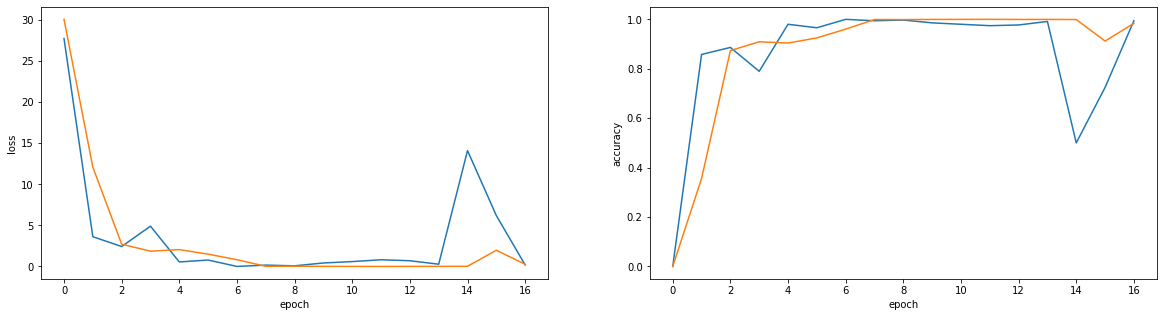

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

axes[0].plot(fit_history.history['val_loss'], label='val_loss')
axes[0].plot(fit_history.history['loss'], label='loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
# axes[0].legend('val_loss')
# axes[0].set_yscale('log'),

axes[1].plot(fit_history.history['val_accuracy'], label='val_accuracy')
axes[1].plot(fit_history.history['accuracy'], label='accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
# axes[0].legend('val_accuracy')
# axes[1].set_yscale('log'),

plt.show()

In [102]:
eval = model_1.evaluate(test_generator, steps=steps_per_epoch_testing, verbose=0)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

Model performance:
loss for test dataset is : 0.0007457567844539881
accuracy for test dataset is : 1.0


In [103]:
#evaluate the model
eval = model_1.evaluate(val_generator,steps=steps_per_epoch_validation, verbose=0)
print('Model performance:')
print('loss for validation dataset is : {}'.format(eval[0]))
print('accuracy for validation dataset is : {}'.format(eval[1]))

Model performance:
loss for validation dataset is : 0.000759100541472435
accuracy for validation dataset is : 1.0


In [104]:
arc_model = Model(input, x)
arc_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        1849

In [105]:
# triple loss, contrastive loss.

In [106]:
arc_model.save_weights('Char74K_keras_arcface.h5')

In [107]:
emb_generator = keras_generator(test_df,batch_size=1, size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=False)

In [108]:
from tqdm import tqdm

In [112]:
# сформируем список embedings для всех классов.
# необходимо подобрать стреднее знаение embedign. для всех классов.
# так чтобы интересующее нас значение находилос в центре области.
# Но, пока доверимся случаю.
embds_dict = {}
# counts = len(train_df)

# for i in range(62):
#     embds_dict[i] =  

for _ in tqdm(range(len(test_df))):
    for img, label in emb_generator:
        break
    emb = arc_model.predict(img)
    embds_dict[np.argmax(label)] = emb[0]

len(embds_dict)

100%|██████████| 5940/5940 [04:28<00:00, 22.10it/s]


62

In [113]:
# сохраним этот список в файл.
import pickle

In [114]:

# Сделаем бекап обученного text_vectorizer.
pickle.dump(embds_dict, open("chars74k_embds.pkl", "wb"))

In [115]:
# Чтобы востановить из бекапа - Раскомментируй !!!
# embds_dict = pickle.load(open("chars74k_embds.pkl", "rb"))

In [131]:
for img, label in keras_generator(val_df,batch_size=16, size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=False):
    break

emb = arc_model.predict(img)[0]

dists = []
for name_2, emb_2 in embds_dict.items():
    dist = np.sum(np.square(emb - emb_2))
    dists.append((dist, name_2, class_name[name_2]))
    print(f"Distance between {np.argmax(y_test[N])} {name_2} = {dist}")


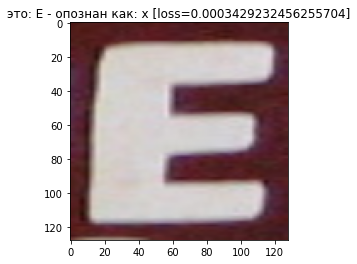

In [139]:
N = 3
plt.imshow(img[N])
plt.title(f'это: {class_name[np.argmax(label[N])]} - опознан как: {class_name[sorted(dists)[0][1]]} [loss={sorted(dists)[0][0]}]')
plt.show()

In [138]:
np.argmax(label[N])

10

In [137]:
sorted(dists)

[(0.00034292325, 59),
 (0.0011219578, 19),
 (0.0023492177, 13),
 (0.0035061473, 2),
 (0.0060952553, 0),
 (0.006286295, 48),
 (0.007329394, 38),
 (0.0074285655, 15),
 (0.0075456123, 1),
 (0.008418948, 37),
 (0.008855335, 21),
 (0.012046794, 56),
 (0.0164663, 25),
 (0.026576456, 47),
 (0.029156877, 32),
 (0.030531067, 4),
 (0.030687677, 14),
 (0.031222373, 9),
 (0.03282603, 18),
 (0.034569707, 53),
 (0.03824338, 50),
 (0.041429855, 43),
 (0.04190845, 22),
 (0.041990917, 11),
 (0.042679507, 52),
 (0.055675212, 49),
 (0.058864094, 27),
 (0.061251156, 39),
 (0.06487795, 58),
 (0.072587155, 36),
 (0.077338025, 61),
 (0.081944264, 35),
 (0.09150625, 51),
 (0.09205971, 34),
 (0.09976506, 55),
 (0.10271858, 54),
 (0.103381485, 28),
 (0.11197834, 20),
 (0.115634464, 3),
 (0.12920389, 31),
 (0.1354011, 8),
 (0.13611442, 16),
 (0.1363235, 5),
 (0.13857317, 24),
 (0.14039153, 33),
 (0.14148861, 17),
 (0.15531719, 42),
 (0.16036807, 57),
 (0.16428521, 46),
 (0.16741608, 10),
 (0.16844247, 6),
 (0.17

In [118]:
len(sorted(dists))

62

In [119]:
emb_generator = keras_generator(train_df,batch_size=1, size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=False)

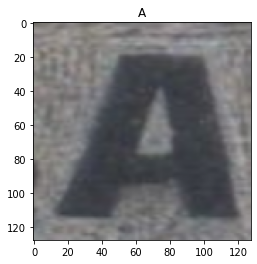

In [120]:
for img, label in emb_generator:
    break

title_text = class_name[np.argmax(label[0])]
plt.imshow(img[0])
plt.title(title_text)
plt.show()

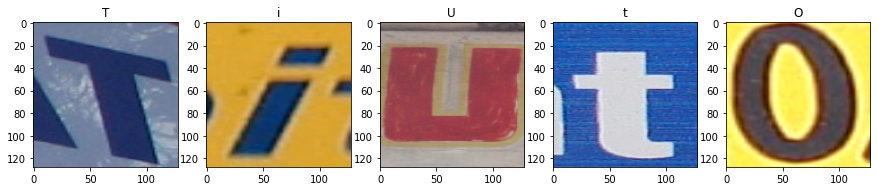

In [121]:
# Проверим работу генератора.

for batchX,batchy in keras_generator(train_df,batch_size=batch_size,size_image=(IMAGE_SIZE,IMAGE_SIZE)):
    break

show_images(batchX[0:5], batchy[0:5])

In [122]:
# show_images(img, label)

In [123]:
# model.load_weights('model.hdf5')
# model = Model(inputs=model.input[0], outputs=model.layers[-3].output)
# embedded_features = model.predict(x_test, verbose=1)
# embedded_features /= np.linalg.norm(embedded_features, axis=1, keepdims=True)

In [124]:
# train_generator = keras_generator(train_df,batch_size=batch_size_training,size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=True)

# test_generator_pred = keras_generator(test_df,batch_size=batch_size_testing,size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=False)

# val_generator_pred = keras_generator(val_df,batch_size=batch_size_validation,size_image=(IMAGE_SIZE,IMAGE_SIZE),is_ArcFace=False)


In [125]:
# #evaluate the model
# eval = arc_model.evaluate(val_generator_pred,steps=steps_per_epoch_validation, verbose=0)
# print('Model performance:')
# print('loss for validation dataset is : {}'.format(eval[0]))
# print('accuracy for validation dataset is : {}'.format(eval[1]))